In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-groq langchain-community
#%pip langchain-anthropic
#%pip langchain-openai

In [ ]:
import getpass
import os
from pprint import pprint
from google.colab import userdata


def _set_env(var: str):
    if not os.environ.get(var):
#        os.environ[var] = getpass.getpass(f"{var}: ")
        os.environ[var] = userdata.get(var)

In [ ]:
_set_env("GROQ_API_KEY")

## Build a Basic Chatbot

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-2.5-32b",
               temperature=0,
               max_tokens=256,
               max_retries=2)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [ ]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

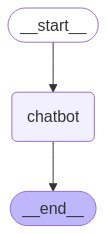

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
response = graph.invoke({"messages": [{"role": "user", "content": "What is agentic ai?"}]})

In [ ]:
response['messages'][-1].content

'Agentic AI refers to artificial intelligence systems that are designed to act autonomously and purposefully, much like agents in the real world. These AI systems are capable of making decisions and taking actions based on their objectives, often in complex and dynamic environments. The term "agentic" emphasizes the AI\'s ability to act independently, with a sense of agency, to achieve specific goals.\n\nAgentic AI can be found in various applications, such as autonomous vehicles, where the AI makes real-time decisions to navigate and avoid obstacles; in virtual assistants that can perform tasks on behalf of users; and in complex simulations or games where AI entities must make strategic decisions to achieve victory or other objectives.\n\nThe development of agentic AI involves advanced algorithms and models, including reinforcement learning, which allows AI to learn from its interactions with the environment, and decision-making processes that can adapt to new situations.'

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        response = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
        print("Assistant:", response['messages'][-1].content)
#        print("Assistant:", response['messages'])

    except:
        break

User: hi
Assistant: Hello! How can I assist you today?
User: what is your name
Assistant: My name is Qwen. I am a large language model created by Alibaba Cloud.
User: what is agent
Assistant: The term "agent" can have different meanings depending on the context in which it is used. Here are a few common interpretations:

1. **In Business and Commerce**: An agent is someone who acts on behalf of another person or organization. This could include real estate agents, travel agents, or agents who represent clients in negotiations or transactions.

2. **In Computer Science and Artificial Intelligence**: An agent is a software entity that can act independently to some extent, often to perform tasks on behalf of users or to interact with other agents. Agents can be simple, like a software program that automatically updates your computer, or complex, like autonomous robots or AI systems that can make decisions based on their environment.

3. **In Literature and Media**: An agent can refer to a

## Adding Tools

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_tool_builder = StateGraph(State)

from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-2.5-32b",
               temperature=0,
               max_tokens=256,
               max_retries=2)

In [ ]:
_set_env("TAVILY_API_KEY")

In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [ ]:
llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
graph_tool_builder.add_node("chatbotWithTools", chatbot_with_tools)

tool_node = ToolNode(tools=[tool])
graph_tool_builder.add_node("tools", tool_node)

graph_tool_builder.add_conditional_edges(
    "chatbotWithTools",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_tool_builder.add_edge("tools", "chatbotWithTools")
graph_tool_builder.set_entry_point("chatbotWithTools")
tool_graph = graph_tool_builder.compile()

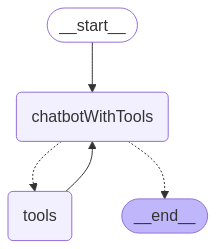

In [ ]:
from IPython.display import Image, display

try:
    display(Image(tool_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

#        print("User: " + user_input)
        response = tool_graph.invoke({"messages": [{"role": "user", "content": user_input}]})
        print("Assistant:", response['messages'][-1].content)
#        print("Assistant:", response['messages'])

    except:
        break

User: what is a agent?
Assistant: An agent, in a general context, can refer to several different concepts depending on the field or context it is used in. Here are a few common interpretations:

1. **Business/Commerce**: An agent is someone who acts on behalf of another person or organization, often in the context of buying, selling, or negotiating. For example, a real estate agent helps clients buy or sell properties.

2. **Computer Science/Artificial Intelligence**: An agent is a software entity that can perceive its environment through sensors and act upon that environment through effectors. It operates autonomously and is often designed to perform specific tasks or solve problems.

3. **Legal**: In legal contexts, an agent is a person authorized to act on behalf of another, such as a lawyer representing a client in court.

4. **Security**: In the context of security, an agent can refer to a software program that monitors and reports on the security status of a computer system.

If 

## Adding Memory to Graph

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
graph_tool_builder = StateGraph(State)

graph_tool_builder.add_node("chatbotWithTools", chatbot_with_tools)

tool_node = ToolNode(tools=[tool])
graph_tool_builder.add_node("tools", tool_node)

graph_tool_builder.add_conditional_edges(
    "chatbotWithTools",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_tool_builder.add_edge("tools", "chatbotWithTools")
graph_tool_builder.set_entry_point("chatbotWithTools")
tool_graph = graph_tool_builder.compile(checkpointer=memory)

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

#        print("User: " + user_input)
        response = tool_graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config)
        print("Assistant:", response['messages'][-1].content)
#        print("Assistant:", response['messages'])

    except:
        break

User: who has won 2025 icc championship trophy?
Assistant: According to the latest information, India has won the 2025 ICC Champions Trophy, which was hosted in Pakistan and the UAE.
User: who won it?
Assistant: India won the 2025 ICC Champions Trophy.
User: who was the man of the match?
Assistant: The information provided does not include the man of the match for the 2025 ICC Champions Trophy. To give you an accurate answer, I would need to perform a more detailed search. Would you like me to proceed with that?
User: quit?
Assistant: If you have any other questions or need further assistance, feel free to ask. If not, I can conclude this session. Let me know how you'd like to proceed!
User: quit
Goodbye!


## Time Travel

In [ ]:
for state in tool_graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)

Num Messages:  10 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  9 Next:  ('chatbotWithTools',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbotWithTools',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbotWithTools',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
---------------

In [ ]:
for state in tool_graph.get_state_history(config):
    if len(state.values["messages"]) == 5:
        to_replay = state

In [ ]:
print(to_replay.next)
print(to_replay.config)

('chatbotWithTools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f006265-4f02-638c-8005-2c9ed739862c'}}


In [ ]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
response = tool_graph.invoke(None,
                             to_replay.config,
                             stream_mode="values")

In [ ]:
print("Assistant:", response['messages'][-1].content)

Assistant: India won the 2025 ICC Champions Trophy.


## Tracing with Langsmith

In [ ]:
!export LANGSMITH_TRACING=true

In [ ]:
_set_env("LANGSMITH_API_KEY")

In [ ]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_tool_builder = StateGraph(State)

from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-2.5-32b",
               temperature=0,
               max_tokens=256,
               max_retries=2)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_tool_builder = StateGraph(State)

graph_tool_builder.add_node("chatbotWithTools", chatbot_with_tools)

tool_node = ToolNode(tools=[tool])
graph_tool_builder.add_node("tools", tool_node)

graph_tool_builder.add_conditional_edges(
    "chatbotWithTools",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_tool_builder.add_edge("tools", "chatbotWithTools")
graph_tool_builder.set_entry_point("chatbotWithTools")
tool_graph = graph_tool_builder.compile(checkpointer=memory)

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        response = tool_graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config)
        print("Assistant:", response['messages'][-1].content)
    except:
        break

User: who won icc championship trophy in 2025?
Assistant: According to the information, India won the ICC Champions Trophy in 2025.
User: who was man of the series?
Assistant: The provided information does not specify who was named the Man of the Series for the ICC Champions Trophy in 2025. To give you an accurate answer, I would need to perform another search. Would you like me to proceed with that?
User: where the match was played?
Assistant: Based on the information available, the ICC Champions Trophy 2025 was hosted by Pakistan and the United Arab Emirates (UAE). However, the specific venues for each match, including the final, are not detailed in the provided information. To get the exact locations where the matches were played, we would need to look up the schedule or results from the tournament. Would you like me to search for that information?
User: who won in 2019?


## Human In the Loop

In [ ]:
from langgraph.types import Command, interrupt
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from typing import Literal
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [ ]:
_set_env("GROQ_API_KEY")
_set_env("TAVILY_API_KEY")

In [ ]:
llm = ChatGroq(model="qwen-2.5-32b",
               temperature=0,
               max_tokens=1024,
               max_retries=2)

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder_human = StateGraph(State)

def human_approval(state: State) -> Command[Literal["chatbotWithTools",
                                                    END]]:
    human_response = interrupt({"query": "Do I search Internet?"})

    print(human_response["data"])

    last_message = state["messages"][-1]
    print("last message:", last_message.content)

    if human_response["data"] == "yes":
        print("Calling chatbot")
        return Command(goto="chatbotWithTools", update={"messages": last_message.content})
    else:
        print("END")
        return Command(goto=END)

tool = TavilySearchResults(max_results=5)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: State):
    print("chatbot message received: ", state["messages"])
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
graph_builder_human.add_node("human_approval", human_approval)
graph_builder_human.add_node("chatbotWithTools", chatbot_with_tools)

tool_node = ToolNode(tools=[tool])
graph_builder_human.add_node("tools", tool_node)

graph_builder_human.add_conditional_edges(
    "chatbotWithTools",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder_human.add_edge("tools", "chatbotWithTools")

graph_builder_human.add_edge(START, "human_approval")

memory = MemorySaver()
graph_human = graph_builder_human.compile(checkpointer=memory)

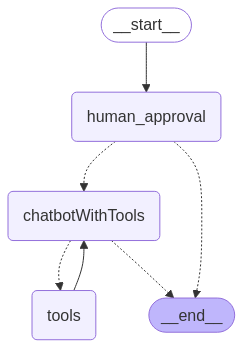

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph_human.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_query = "Who won the ICC championship trophy recently?"
user_input = {"messages": [{"role": "user", "content": user_query}]}
config = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph_human.stream(user_input, config, stream_mode="updates"):
    print(event)
    print("\n")

#response = graph_human.stream({"messages": [{"role": "user", "content": user_input}]}, config)

{'__interrupt__': (Interrupt(value={'query': 'Do I search Internet?'}, resumable=True, ns=['human_approval:340f3c9a-1352-e53c-26af-782b71b10007']),)}




In [ ]:
snapshot = graph_human.get_state(config)
snapshot.next

('human_approval',)

In [ ]:
config = {"configurable": {"thread_id": "2"}}
human_command = Command(resume={"data": "yes"})

for event in graph_human.stream(
   human_command, config, stream_mode="updates"):
   print(event)
   print("\n")

yes
last message: Who won the ICC championship trophy recently?
Calling chatbot
{'human_approval': {'messages': 'Who won the ICC championship trophy recently?'}}


chatbot message received:  [HumanMessage(content='Who won the ICC championship trophy recently?', additional_kwargs={}, response_metadata={}, id='03fa8181-d64b-4f00-bba8-42726f52879a'), HumanMessage(content='Who won the ICC championship trophy recently?', additional_kwargs={}, response_metadata={}, id='1bd68cf6-6167-4458-a85e-0e91eed8e900')]
{'chatbotWithTools': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qf4d', 'function': {'arguments': '{"query": "ICC championship trophy winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 227, 'total_tokens': 254, 'completion_time': 0.135, 'prompt_time': 0.016269397, 'queue_time': 0.38948099199999997, 'total_time': 0.151269397}, 'model_name': 'qwen-2.5-32